In [1]:
import utils
from train import Trainer, Tuner
from pathlib import Path
from model.bigger_leaky_unet import BiggerLeakyUnet
from IPython.display import Image
from IPython.core.display import HTML 

import seaborn as sns
sns.set()

%load_ext autoreload
%autoreload 2

## optimization params

What can we optimize?

1. learning rate (very important for us);
2. batch size (unusually important and we forced to use very small batches);
3. image size (224, 256 etc.);
4. model: 
    - increase number of layers (looks like we need much bigger model than the regular one); 
    - add batch normalization (?);
    - use `LeakyReLU`;
5. advanced model:
    - use attention;
    - use transfer learning;

Here's the list of hyperparameters from cs230 - see [here](https://cs230.stanford.edu/files/C2M3.pdf). It seems we work with the learning rate, it's decay, # of layers and mini-batch size. 

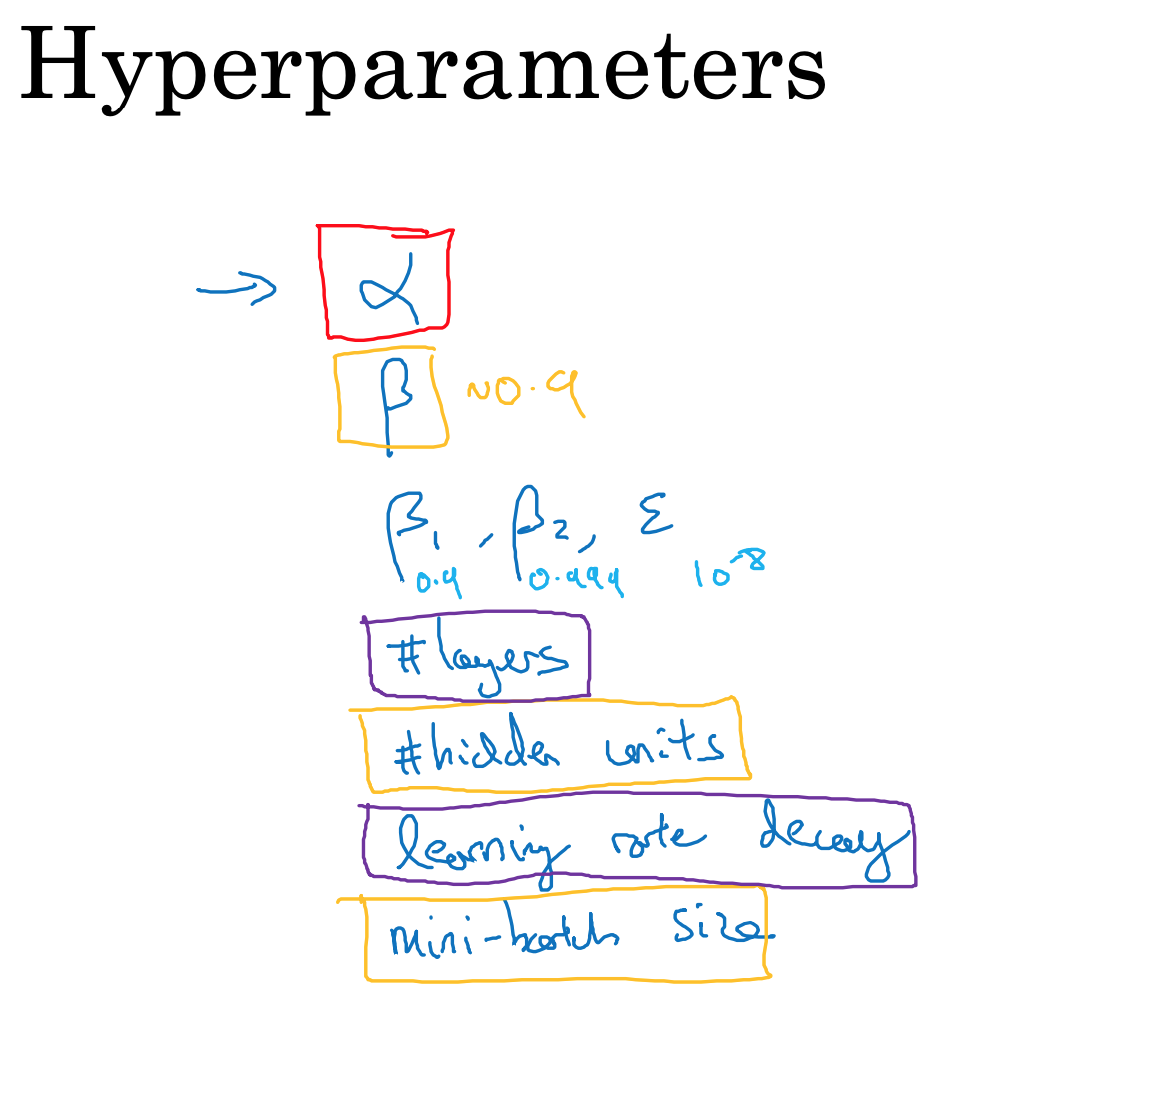

In [29]:
Image('misc/parameter_tuning_cs230.png', width=300, height=400)

### questions

- What about initialization?
- Maybe we should use another optimizer - it seems the model is quite sensitive to learning rate; many of them just doesn't work; also what about generalization? looks like their best model - UNet, not BigUnet - very strange;

## `BiggerLeakyUnet`

### `learning_rate` search

Let's try to find an optimal learning rate for this model. We start search from a broad range of rates: `(1e-1, 1e-2, 1e-3, 1e-4, 1e-5)` and train our model for just 3 epochs. We then try to look into rates around the best one.

We may see that it's not easy to find a good learning rate. Basically *nothing works* except `1e-5` and maybe `1e-6` (for 3 epochs). Especially *bad* choice - `1e-4` (again, at least for 3 epochs). So probably it's not going to be easy to train as well.

In [16]:
Image(url='http://cs231n.github.io/assets/nn3/learningrates.jpeg', width=200, height=200)

In [17]:
dir_path = Path('experiments/bigger_leaky_unet')

In [27]:
history = utils.load_history(dir_path / 'history_learning_rate_1e-05.pickle')

In [28]:
history.keys()

dict_keys(['loss', 'jaccard_coef', 'val_loss', 'val_jaccard_coef', 'lr'])

In [57]:
histories_lr = list(dir_path.glob('history_learning_rate*'))

In [58]:
histories_lr

[PosixPath('experiments/bigger_leaky_unet/history_learning_rate_0.0001.pickle'),
 PosixPath('experiments/bigger_leaky_unet/history_learning_rate_0.001.pickle'),
 PosixPath('experiments/bigger_leaky_unet/history_learning_rate_0.01.pickle'),
 PosixPath('experiments/bigger_leaky_unet/history_learning_rate_0.1.pickle'),
 PosixPath('experiments/bigger_leaky_unet/history_learning_rate_7e-06.pickle'),
 PosixPath('experiments/bigger_leaky_unet/history_learning_rate_5e-06.pickle'),
 PosixPath('experiments/bigger_leaky_unet/history_learning_rate_1e-06.pickle'),
 PosixPath('experiments/bigger_leaky_unet/history_learning_rate_3e-05.pickle'),
 PosixPath('experiments/bigger_leaky_unet/history_learning_rate_1e-05.pickle')]

In [59]:
histories_lr[:4]

[PosixPath('experiments/bigger_leaky_unet/history_learning_rate_0.0001.pickle'),
 PosixPath('experiments/bigger_leaky_unet/history_learning_rate_0.001.pickle'),
 PosixPath('experiments/bigger_leaky_unet/history_learning_rate_0.01.pickle'),
 PosixPath('experiments/bigger_leaky_unet/history_learning_rate_0.1.pickle')]

We may see that rates bigger than `1e-5` don't work.

In [60]:
bad_histories = histories_lr[:4]+histories_lr[7:8]

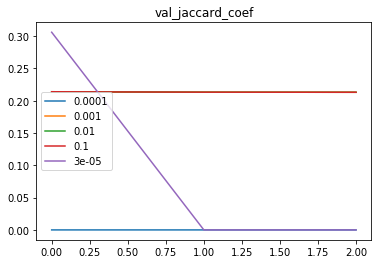

In [61]:
utils.plot_metric_paths('val_jaccard_coef', bad_histories)

But rates from `.5e-6` to `1e-5` do work. And `1e-6` is too small (no significant improvement for 3 epochs). We may start from `1e-5` and use `ReduceLROnPlateau` callback with `factor=0.75`.

In [50]:
x = 1e-5
for i in range(10):
    print(f'{x:.4}')
    x *= .75

1e-05
7.5e-06
5.625e-06
4.219e-06
3.164e-06
2.373e-06
1.78e-06
1.335e-06
1.001e-06
7.508e-07


In [62]:
good_histories = histories_lr[4:7] + [histories_lr[8]]

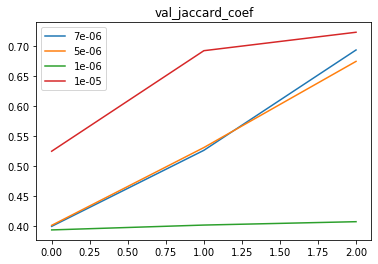

In [63]:
utils.plot_metric_paths('val_jaccard_coef', good_histories)

### `batch_size` search

It looks like this model ia also sensitive to the size of batch. Better to use small batches.

In [73]:
histories_bs = list(dir_path.glob('history_batch_size*'))

In [74]:
histories_bs

[PosixPath('experiments/bigger_leaky_unet/history_batch_size_2.pickle'),
 PosixPath('experiments/bigger_leaky_unet/history_batch_size_4.pickle'),
 PosixPath('experiments/bigger_leaky_unet/history_batch_size_8.pickle'),
 PosixPath('experiments/bigger_leaky_unet/history_batch_size_16.pickle'),
 PosixPath('experiments/bigger_leaky_unet/history_batch_size_32.pickle')]

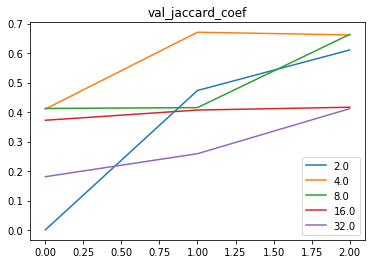

In [75]:
utils.plot_metric_paths('val_jaccard_coef', histories_bs)

Let's also try to train for 10 epochs for small batch sizes.

### `batch_size` search - 10 epochs

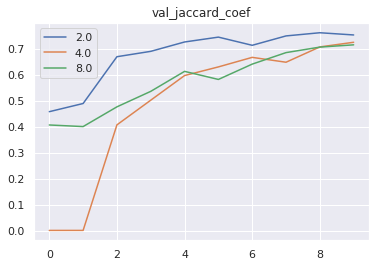

In [83]:
utils.plot_metric_paths('val_jaccard_coef', histories_bs[:3])

### `learning_rate` tuning on toy dataset

We may see that results are the same for some rates, the only difference is for `1e-4` that seems promising on the small dataset. Probably we should do additional testing for it on our actual dataset.

In [19]:
dir_path = Path('experiments/bigger_leaky_unet_toy')

In [20]:
histories_lr_toy = list(dir_path.glob('history_learning_rate*'))

In [21]:
histories_lr_toy = sorted(histories_lr_toy, key=utils.get_param_num, reverse=True)

In [22]:
histories_lr_toy

[PosixPath('experiments/bigger_leaky_unet_toy/history_learning_rate_0.001.pickle'),
 PosixPath('experiments/bigger_leaky_unet_toy/history_learning_rate_0.0001.pickle'),
 PosixPath('experiments/bigger_leaky_unet_toy/history_learning_rate_1e-05.pickle'),
 PosixPath('experiments/bigger_leaky_unet_toy/history_learning_rate_1e-06.pickle')]

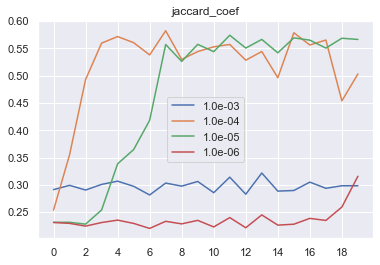

In [23]:
utils.plot_metric_paths('jaccard_coef', histories_lr_toy)

### `batch_size` tuning on toy dataset

In [2]:
dir_path = Path('experiments/bigger_leaky_unet_toy')

In [3]:
histories_bs_toy = list(dir_path.glob('history_batch_size*'))

In [13]:
histories_bs_toy = sorted(histories_bs_toy, key=utils.get_param_num)

In [14]:
histories_bs_toy

[PosixPath('experiments/bigger_leaky_unet_toy/history_batch_size_2.pickle'),
 PosixPath('experiments/bigger_leaky_unet_toy/history_batch_size_4.pickle'),
 PosixPath('experiments/bigger_leaky_unet_toy/history_batch_size_8.pickle'),
 PosixPath('experiments/bigger_leaky_unet_toy/history_batch_size_16.pickle'),
 PosixPath('experiments/bigger_leaky_unet_toy/history_batch_size_32.pickle')]

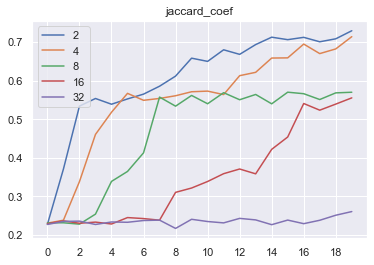

In [17]:
utils.plot_metric_paths('jaccard_coef', histories_bs_toy, scientific=False)